## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3, 0.5, 0.7]
redice_lr_patient = [5,8,10]

In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 2s 39us/step - loss: 1.2276 - acc: 0.5787 - val_loss: 1.4704 - val_acc: 0.4846
Epoch 14/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.2023 - acc: 0.5881 - val_loss: 1.4707 - val_acc: 0.4784
Epoch 15/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.1776 - acc: 0.5981 - val_loss: 1.4625 - val_acc: 0.4891
Epoch 16/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.1529 - acc: 0.6055 - val_loss: 1.4619 - val_acc: 0.4851
Epoch 17/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.1311 - acc: 0.6144 - val_loss: 1.4559 - val_acc: 0.4876
Epoch 18/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.1081 - acc: 0.6215 - val_loss: 1.4548 - val_acc: 0.4927
Epoch 19/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.0867 - acc: 0.6306 - val_loss: 1.4589 - val_acc: 0.4910
Epoch 20/25
50000/50000 [=====================

50000/50000 [==============================] - 3s 51us/step - loss: 2.2156 - acc: 0.2677 - val_loss: 2.0711 - val_acc: 0.3161
Epoch 2/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.7461 - acc: 0.3905 - val_loss: 1.7807 - val_acc: 0.3898
Epoch 3/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.6227 - acc: 0.4325 - val_loss: 1.6975 - val_acc: 0.4084
Epoch 4/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.5501 - acc: 0.4550 - val_loss: 1.6362 - val_acc: 0.4238
Epoch 5/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.4954 - acc: 0.4770 - val_loss: 1.6002 - val_acc: 0.4399
Epoch 6/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.4494 - acc: 0.4919 - val_loss: 1.5786 - val_acc: 0.4421
Epoch 7/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.4116 - acc: 0.5080 - val_loss: 1.5459 - val_acc: 0.4544
Epoch 8/25
50000/50000 [============================

50000/50000 [==============================] - 2s 43us/step - loss: 1.1803 - acc: 0.5945 - val_loss: 1.4852 - val_acc: 0.4784
Epoch 25/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.1657 - acc: 0.6013 - val_loss: 1.4855 - val_acc: 0.4836
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.3879 - acc: 0.5157 - val_loss: 1.5739 - val_acc: 0.4485
Epoch 13/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.3664 - acc: 0.5248 - val_loss: 1.5572 - val_acc: 0.4530
Epoch 14/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.3459 - acc: 0.5320 - val_loss: 1.5469 - val_acc: 0.4585
Epoch 15/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.3266 - acc: 0.5391 - val_loss: 1.5453 - val_acc: 0.4573
Epoch 16/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.3080 - acc: 0.5457 - val_loss: 1.5366 - val_acc: 0.4625
Epoch 17/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.2914 - acc: 0.5514 - val_loss: 1.5331 - val_acc: 0.4588
Epoch 18/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.2740 - acc: 0.5590 - val_loss: 1.5182 - val_acc: 0.4687
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 54us/step - loss: 2.4123 - acc: 0.2284 - val_loss: 2.3239 - val_acc: 0.2496
Epoch 2/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.8870 - acc: 0.3533 - val_loss: 2.0298 - val_acc: 0.3257
Epoch 3/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.7389 - acc: 0.3991 - val_loss: 1.8204 - val_acc: 0.3726
Epoch 4/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.6578 - acc: 0.4244 - val_loss: 1.7397 - val_acc: 0.3944
Epoch 5/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.5980 - acc: 0.4437 - val_loss: 1.6910 - val_acc: 0.4089
Epoch 6/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.5527 - acc: 0.4585 - val_loss: 1.6620 - val_acc: 0.4182
Epoch 7/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.5164 - acc: 0.4717 - val_loss: 1.6252 - val_acc

50000/50000 [==============================] - 3s 53us/step - loss: 0.6116 - acc: 0.8110 - val_loss: 1.3909 - val_acc: 0.5316
Epoch 23/25
50000/50000 [==============================] - 2s 49us/step - loss: 0.6042 - acc: 0.8149 - val_loss: 1.4020 - val_acc: 0.5323
Epoch 24/25
50000/50000 [==============================] - 2s 48us/step - loss: 0.5992 - acc: 0.8164 - val_loss: 1.4043 - val_acc: 0.5329
Epoch 25/25
50000/50000 [==============================] - 2s 48us/step - loss: 0.5957 - acc: 0.8181 - val_loss: 1.4067 - val_acc: 0.5315
Numbers of exp: 10, reduce_factor: 0.30, reduce_patient: 8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch

Epoch 10/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.2459 - acc: 0.5698 - val_loss: 1.4801 - val_acc: 0.4809
Epoch 11/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.2213 - acc: 0.5792 - val_loss: 1.4649 - val_acc: 0.4826
Epoch 12/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.1998 - acc: 0.5873 - val_loss: 1.4794 - val_acc: 0.4812
Epoch 13/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.1788 - acc: 0.5963 - val_loss: 1.4679 - val_acc: 0.4834
Epoch 14/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.1600 - acc: 0.6020 - val_loss: 1.4830 - val_acc: 0.4787
Epoch 15/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.1392 - acc: 0.6110 - val_loss: 1.4535 - val_acc: 0.4887
Epoch 16/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.1210 - acc: 0.6185 - val_loss: 1.4600 - val_acc: 0.4886
Epoch 17/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.9328 - acc: 0.3418 - val_loss: 1.9320 - val_acc: 0.3514
Epoch 2/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.5915 - acc: 0.4430 - val_loss: 1.6814 - val_acc: 0.4088
Epoch 3/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.4930 - acc: 0.4776 - val_loss: 1.6345 - val_acc: 0.4121
Epoch 4/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.4294 - acc: 0.5022 - val_loss: 1.5765 - val_acc: 0.4412
Epoch 5/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.3818 - acc: 0.5206 - val_loss: 1.5457 - val_acc: 0.4534
Epoch 6/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.3401 - acc: 0.5344 - val_loss: 1.5148 - val_acc: 0.4666
Epoch 7/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.3063 - acc: 0.5506 - val_loss: 1.4974 - val_acc

50000/50000 [==============================] - 2s 47us/step - loss: 0.9751 - acc: 0.6770 - val_loss: 1.4357 - val_acc: 0.5015
Epoch 25/25
50000/50000 [==============================] - 2s 49us/step - loss: 0.9598 - acc: 0.6849 - val_loss: 1.4398 - val_acc: 0.5000
Numbers of exp: 15, reduce_factor: 0.70, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_46 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

50000/50000 [==============================] - 2s 40us/step - loss: 1.2758 - acc: 0.5632 - val_loss: 1.4913 - val_acc: 0.4750
Epoch 12/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.2563 - acc: 0.5707 - val_loss: 1.4917 - val_acc: 0.4739
Epoch 13/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.2371 - acc: 0.5773 - val_loss: 1.4905 - val_acc: 0.4782
Epoch 14/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.2189 - acc: 0.5831 - val_loss: 1.4828 - val_acc: 0.4807
Epoch 15/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.2024 - acc: 0.5908 - val_loss: 1.4709 - val_acc: 0.4839
Epoch 16/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.1862 - acc: 0.5978 - val_loss: 1.4770 - val_acc: 0.4819
Epoch 17/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.1713 - acc: 0.6035 - val_loss: 1.4627 - val_acc: 0.4868
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.7954 - acc: 0.3747 - val_loss: 1.9507 - val_acc: 0.3228
Epoch 2/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.5373 - acc: 0.4563 - val_loss: 2.1937 - val_acc: 0.2671
Epoch 3/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.4390 - acc: 0.4917 - val_loss: 2.0886 - val_acc: 0.2874
Epoch 4/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.3605 - acc: 0.5191 - val_loss: 2.2931 - val_acc: 0.2930
Epoch 5/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.2991 - acc: 0.5415 - val_loss: 1.8662 - val_acc: 0.3516
Epoch 6/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.2520 - acc: 0.5611 - val_loss: 2.2835 - val_acc: 0.2888
Epoch 7/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.2131 - acc: 0.5715 - val_loss: 1.9124 - val_acc

50000/50000 [==============================] - 2s 41us/step - loss: 0.7914 - acc: 0.7479 - val_loss: 1.4272 - val_acc: 0.5078
Epoch 23/25
50000/50000 [==============================] - 2s 44us/step - loss: 0.7741 - acc: 0.7564 - val_loss: 1.4322 - val_acc: 0.5071
Epoch 24/25
50000/50000 [==============================] - 2s 46us/step - loss: 0.7629 - acc: 0.7614 - val_loss: 1.4482 - val_acc: 0.5062
Epoch 25/25
50000/50000 [==============================] - 2s 49us/step - loss: 0.7517 - acc: 0.7668 - val_loss: 1.4462 - val_acc: 0.5059
Numbers of exp: 20, reduce_factor: 0.30, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batc

Epoch 10/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.4015 - acc: 0.5160 - val_loss: 1.5774 - val_acc: 0.4471
Epoch 11/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.3740 - acc: 0.5256 - val_loss: 1.5657 - val_acc: 0.4553
Epoch 12/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.3472 - acc: 0.5355 - val_loss: 1.5564 - val_acc: 0.4551
Epoch 13/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.3233 - acc: 0.5434 - val_loss: 1.5358 - val_acc: 0.4625
Epoch 14/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.3020 - acc: 0.5522 - val_loss: 1.5260 - val_acc: 0.4636
Epoch 15/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.2794 - acc: 0.5614 - val_loss: 1.5324 - val_acc: 0.4656
Epoch 16/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.2602 - acc: 0.5669 - val_loss: 1.5353 - val_acc: 0.4649
Epoch 17/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 87us/step - loss: 2.2253 - acc: 0.2539 - val_loss: 2.0764 - val_acc: 0.3022
Epoch 2/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.8682 - acc: 0.3511 - val_loss: 1.9369 - val_acc: 0.3403
Epoch 3/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.7376 - acc: 0.3926 - val_loss: 1.8150 - val_acc: 0.3694
Epoch 4/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.6548 - acc: 0.4234 - val_loss: 1.7512 - val_acc: 0.3925
Epoch 5/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.5937 - acc: 0.4447 - val_loss: 1.7131 - val_acc: 0.4013
Epoch 6/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.5443 - acc: 0.4607 - val_loss: 1.6631 - val_acc: 0.4261
Epoch 7/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.5012 - acc: 0.4776 - val_loss: 1.6514 - val_acc

50000/50000 [==============================] - 2s 47us/step - loss: 1.1340 - acc: 0.6156 - val_loss: 1.5095 - val_acc: 0.4743
Epoch 25/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.1185 - acc: 0.6236 - val_loss: 1.5089 - val_acc: 0.4741
Numbers of exp: 25, reduce_factor: 0.70, reduce_patient: 8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_76 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.3543 - acc: 0.5318 - val_loss: 1.5863 - val_acc: 0.4486
Epoch 13/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.3302 - acc: 0.5413 - val_loss: 1.5580 - val_acc: 0.4578
Epoch 14/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.3084 - acc: 0.5514 - val_loss: 1.5522 - val_acc: 0.4587
Epoch 15/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.2864 - acc: 0.5572 - val_loss: 1.5438 - val_acc: 0.4625
Epoch 16/25
50000/50000 [==============================] - 2s 43us/step - loss: 1.2676 - acc: 0.5639 - val_loss: 1.5369 - val_acc: 0.4675
Epoch 17/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.2482 - acc: 0.5723 - val_loss: 1.5241 - val_acc: 0.4675
Epoch 18/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.2291 - acc: 0.5803 - val_loss: 1.5266 - val_acc: 0.4691
Epoch 19/25
50000/50000 [=========

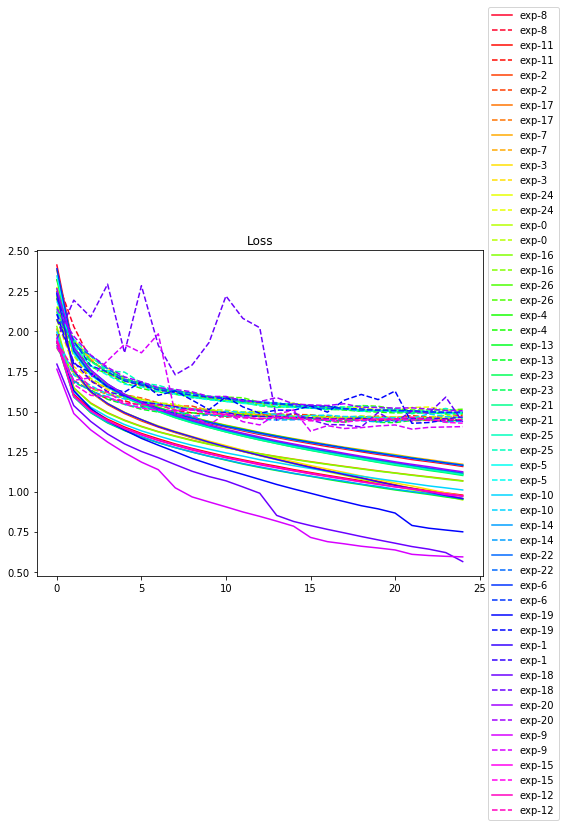

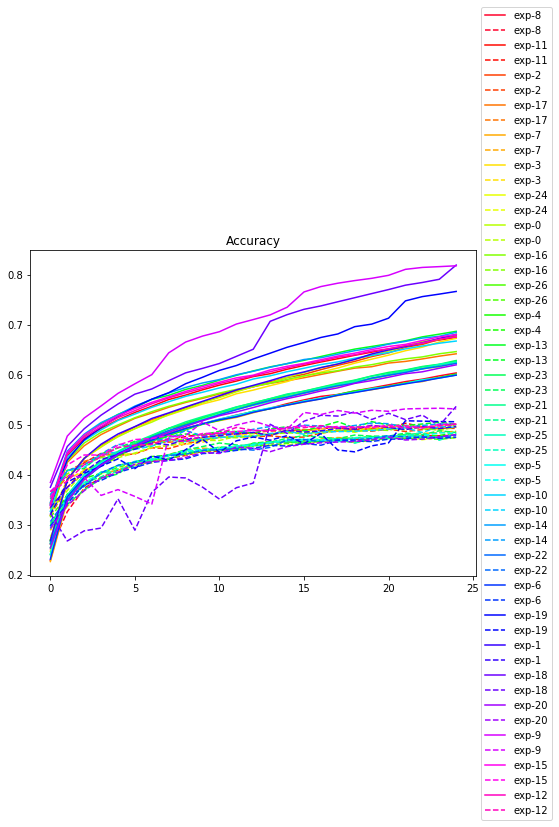

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()